In [1]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import jellyfish
import os
import shutil
import subprocess
import requests
from github import Github
from git import Repo
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import configparser
import h2o
import scipy as sp

## Result Gathering

In [3]:
main_df = None
directory = "Effort_Estimation_Results_3E_v2/"
for filename in os.listdir(directory):
    print(filename)
    if main_df is None:
        main_df = pd.read_csv(os.path.join(directory, filename))
        main_df['project_name'] = filename.replace('.csv', '')
    else:
        temp_df = pd.read_csv(os.path.join(directory, filename))
        temp_df['project_name'] = filename.replace('.csv', '')
        frames = [main_df, temp_df]
        main_df = pd.concat(frames)

Alluxio.csv
Assertj-core.csv
Atmosphere.csv
AxonFramework.csv
Beam.csv
Byte-buddy.csv
Camel.csv
Cas.csv
Cassandra.csv
Cxf.csv
Dbeaver.csv
Eclim.csv
Guacamole-client.csv
Hadoop.csv
Hawtio.csv
karaf.csv
Okhttp.csv
Openapi-generator.csv
Orientdb.csv
Redisson.csv
Rest-assured.csv
Spring-framework.csv
Spring-security.csv
Storm.csv
Tika.csv
Traccar.csv


In [4]:
main_df.head()

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,2,NaN,8,1.000000,15.00000,4.13952,2.477916,12.48,42.435515
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,1,NaN,346,0.225434,1.00000,179.03424,107.076009,2229.76,519.589347
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,2,0.707107,35,1.000000,1.00000,18.11040,10.840124,189.60,113.234791
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,13,4.018895,194,0.185567,3.71134,100.38336,60.060503,1232.64,353.641141
4,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,136,50.585661,1938,0.004128,1.00000,1002.79872,597.273303,12673.28,1634.048307


In [5]:
for column in main_df:
    print(column)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

In [6]:
len(main_df)

775

In [7]:
main_df['refactoring_perc_time_taken'] = main_df['refactoring_perc'] * main_df['time_taken']

In [8]:
main_df['refactoring_perc_time_taken'].value_counts()

 1.000000    27
 2.000000    23
 3.000000    11
 5.000000     6
 4.000000     6
             ..
 1.867550     1
-0.070658     1
 1.406926     1
 1.515519     1
 7.411236     1
Name: refactoring_perc_time_taken, Length: 667, dtype: int64

In [9]:
def plotGraph(y_test,y_pred,y_test_str,y_pred_str,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
        
    plt.figure(figsize=(15,15))
    plt.scatter(range(len(y_test)), y_test, color='blue', label=y_test_str)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label=y_pred_str)
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.show()
    return

def plotGraphandSave(y_test,y_pred,y_test_str,y_pred_str,regressorName,img_name):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
        
    plt.figure(figsize=(15,15))
    plt.scatter(range(len(y_test)), y_test, color='blue', label=y_test_str)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label=y_pred_str)
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.savefig(f'model_prediction_images/{img_name}.png')
    plt.show()
    return

In [10]:
def get_final_time_taken(row):
    if row['time_taken'] > row['time_taken_q90']:
        return row['time_taken'] - row['time_taken_q90']
    elif row['time_taken'] > row['time_taken_q80']:
        return row['time_taken'] - row['time_taken_q80']
    elif row['time_taken'] > row['time_taken_q60']:
        return row['time_taken'] - row['time_taken_q60']
    elif row['time_taken'] > row['time_taken_q40']:
        return row['time_taken'] - row['time_taken_q40']
    elif row['time_taken'] > row['time_taken_q20']:
        return row['time_taken'] - row['time_taken_q20']

In [11]:
main_df['time_taken_final'] = main_df.apply(lambda row: get_final_time_taken(row), axis=1)



In [12]:
#plotGraph(main_df['time_taken_final'], main_df['time_taken_mean'],' test')

{'whiskers': [<matplotlib.lines.Line2D at 0x20f2955b0f0>,
 'caps': [<matplotlib.lines.Line2D at 0x20f2955bbe0>,
 'boxes': [<matplotlib.lines.Line2D at 0x20f2955b390>],
 'medians': [<matplotlib.lines.Line2D at 0x20f2956f320>],
 'fliers': [<matplotlib.lines.Line2D at 0x20f2956f6a0>],
 'means': []}

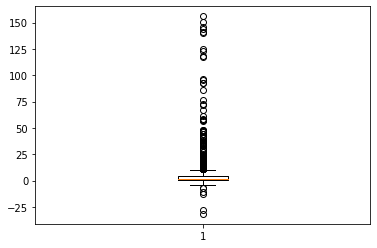

In [13]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

In [14]:
main_df = main_df[main_df['refactoring_perc_time_taken'] > 0]
main_df = main_df[main_df['refactoring_perc_time_taken'] <= 40]
#main_df = main_df[main_df['refactoring_perc_time_taken'] <= 20]

#main_df = main_df[main_df['time_taken_final'] <= 60]
#main_df = main_df[main_df['time_taken_final'] > 2]

{'whiskers': [<matplotlib.lines.Line2D at 0x20f28d1b0f0>,
 'caps': [<matplotlib.lines.Line2D at 0x20f28d1bb38>,
 'boxes': [<matplotlib.lines.Line2D at 0x20f28d1b358>],
 'medians': [<matplotlib.lines.Line2D at 0x20f28d29278>],
 'fliers': [<matplotlib.lines.Line2D at 0x20f28d295f8>],
 'means': []}

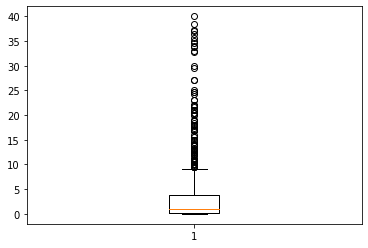

In [15]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

In [16]:
main_df['time_taken_final'].value_counts()

1.0     135
2.0      73
6.0      35
4.0      33
3.0      32
       ... 
11.2      1
1.6       1
0.6       1
1.2       1
3.2       1
Name: time_taken_final, Length: 93, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x20f28d895c0>,
 'caps': [<matplotlib.lines.Line2D at 0x20f28f55080>,
 'boxes': [<matplotlib.lines.Line2D at 0x20f28d89828>],
 'medians': [<matplotlib.lines.Line2D at 0x20f28f55780>],
 'fliers': [<matplotlib.lines.Line2D at 0x20f28f55b00>],
 'means': []}

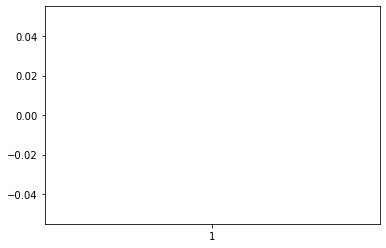

In [17]:
plt.boxplot(main_df['time_taken_final'])

In [18]:
main_df = main_df.fillna(0)

In [19]:
main_df

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken,time_taken_final
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,0.000000,8,1.000000,15.000000,4.13952,2.477916,12.48,42.435515,7.0
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,0.000000,346,0.225434,0.225434,179.03424,107.076009,2229.76,519.589347,0.0
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,0.707107,35,1.000000,1.000000,18.11040,10.840124,189.60,113.234791,0.0
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,13,4.018895,194,0.185567,3.711340,100.38336,60.060503,1232.64,353.641141,1.0
4,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,136,50.585661,1938,0.004128,0.012384,1002.79872,597.273303,12673.28,1634.048307,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,7,1.964427,615,0.053659,0.053659,318.22560,190.190193,3994.40,761.687072,0.0
1,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,3,0.866025,16,0.750000,18.750000,8.27904,4.955729,64.96,67.284406,5.0
2,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,10,2.946898,1696,0.004127,0.198113,877.57824,523.020584,11085.76,1495.349884,9.0
3,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,1,0.000000,535,0.725234,17.405607,276.83040,165.484354,3469.60,694.272395,4.0


(array([533.,  63.,  30.,  23.,  18.,  13.,   6.,   2.,   7.,   5.]),
 array([1.20827670e-04, 4.00010874e+00, 8.00009666e+00, 1.20000846e+01,
        1.60000725e+01, 2.00000604e+01, 2.40000483e+01, 2.80000362e+01,
        3.20000242e+01, 3.60000121e+01, 4.00000000e+01]),
 <a list of 10 Patch objects>)

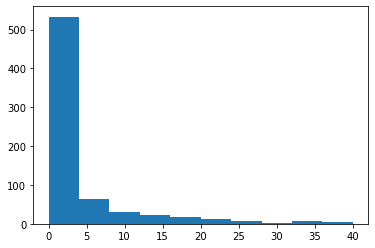

In [20]:
plt.hist(main_df['refactoring_perc_time_taken'])

(array([346., 114.,  40.,  33.,  28.,  17.,   5.,  13.,   5.,  11.,  11.,
          3.,   8.,   6.,   7.,   2.,   5.,   7.,   3.,   3.,   7.,   4.,
          2.,   0.,   4.,   0.,   1.,   1.,   0.,   2.,   0.,   0.,   2.,
          2.,   2.,   1.,   2.,   1.,   1.,   1.]),
 array([1.20827670e-04, 1.00011781e+00, 2.00011479e+00, 3.00011177e+00,
        4.00010874e+00, 5.00010572e+00, 6.00010270e+00, 7.00009968e+00,
        8.00009666e+00, 9.00009364e+00, 1.00000906e+01, 1.10000876e+01,
        1.20000846e+01, 1.30000816e+01, 1.40000785e+01, 1.50000755e+01,
        1.60000725e+01, 1.70000695e+01, 1.80000665e+01, 1.90000634e+01,
        2.00000604e+01, 2.10000574e+01, 2.20000544e+01, 2.30000514e+01,
        2.40000483e+01, 2.50000453e+01, 2.60000423e+01, 2.70000393e+01,
        2.80000362e+01, 2.90000332e+01, 3.00000302e+01, 3.10000272e+01,
        3.20000242e+01, 3.30000211e+01, 3.40000181e+01, 3.50000151e+01,
        3.60000121e+01, 3.70000091e+01, 3.80000060e+01, 3.90000030e+01,
      

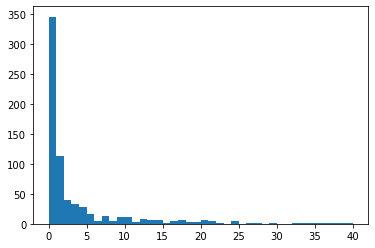

In [21]:
plt.hist(main_df['refactoring_perc_time_taken'],bins=40)

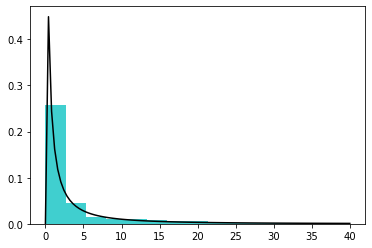

In [22]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=15, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

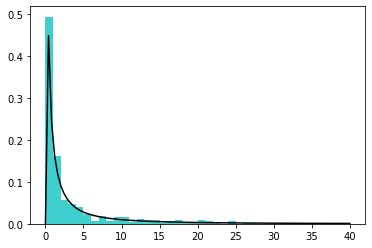

In [23]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=40, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

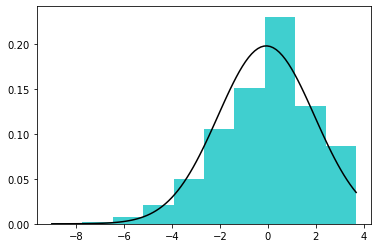

In [24]:
logdata = np.log(main_df['refactoring_perc_time_taken'])
plt.hist(logdata, bins=10, density=True, color='c', alpha=0.75)
xmin = logdata.min()
xmax = logdata.max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.norm.pdf(x, loc=estimated_mu, scale=estimated_sigma)
plt.plot(x, pdf, 'k')

In [25]:
len(main_df)

700

In [26]:
main_df.to_csv('test_effort_model.csv', index=False)

## EDA (Run only if absolutely necessary on minimum features)

In [27]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(main_df, title="Pandas Profiling Report",explorative=True)
#profile

In [28]:
for columns in main_df.columns:
    print(columns)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

### Only taking mean for num_dependency and num_line_affected since there is only one

In [29]:
final_col = []
column_to_skip = ['sha',
'name','email','login',
'date','message',
'parent_sha','parent_date',
'time_taken','contains_refactoring',
'kmean_label','time_taken_mean',
'time_taken_min',
'time_taken_max',
'time_taken_q10',
'time_taken_q20',
'time_taken_q25',
'time_taken_q30',
'time_taken_q40',
'time_taken_q50',
'time_taken_q60',
'time_taken_q70',
'time_taken_q75',
'time_taken_q80',
'time_taken_q90',
'project_name','commit_compared_with',
'actual_num_of_classes_touched_mean',
 'actual_num_of_classes_touched_min',
 'actual_num_of_classes_touched_max',
 'actual_num_of_classes_touched_std',
'num_dependency_min',
'num_dependency_max',
'num_dependency_std',
'num_line_affected_min',
'num_line_affected_max',
'num_line_affected_std', 'time_taken_final',
'commit_line_changed',
'refactoring_perc',
 'cocomoII_time_taken',
'geneticP_time_taken',
'softwareMaintenance_time_taken',
'fuzzy_time_taken',
'time_taken_final'
 ]
for element in main_df.columns:
    #print("'" + element + "',")
    if element not in column_to_skip:
        final_col.append(element)

In [30]:
final_col

['cbo_mean',
 'cbo_min',
 'cbo_max',
 'cbo_std',
 'wmc_mean',
 'wmc_min',
 'wmc_max',
 'wmc_std',
 'dit_mean',
 'dit_min',
 'dit_max',
 'dit_std',
 'rfc_mean',
 'rfc_min',
 'rfc_max',
 'rfc_std',
 'lcom_mean',
 'lcom_min',
 'lcom_max',
 'lcom_std',
 'totalMethods_mean',
 'totalMethods_min',
 'totalMethods_max',
 'totalMethods_std',
 'staticMethods_mean',
 'staticMethods_min',
 'staticMethods_max',
 'staticMethods_std',
 'publicMethods_mean',
 'publicMethods_min',
 'publicMethods_max',
 'publicMethods_std',
 'privateMethods_mean',
 'privateMethods_min',
 'privateMethods_max',
 'privateMethods_std',
 'protectedMethods_mean',
 'protectedMethods_min',
 'protectedMethods_max',
 'protectedMethods_std',
 'defaultMethods_mean',
 'defaultMethods_min',
 'defaultMethods_max',
 'defaultMethods_std',
 'abstractMethods_mean',
 'abstractMethods_min',
 'abstractMethods_max',
 'abstractMethods_std',
 'finalMethods_mean',
 'finalMethods_min',
 'finalMethods_max',
 'finalMethods_std',
 'synchronizedMetho

In [31]:
X_col = final_col.copy()
X_col.remove('refactoring_perc_time_taken')
Y_col = ['refactoring_perc_time_taken']

X = main_df[X_col]
y = main_df[Y_col]
final_df = main_df[final_col]

In [32]:
X.head()

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
0,11.000000,11.0,11.0,0.000000,8.000000,8.0,8.0,0.000000,2.000000,2.0,...,58.000000,58.0,58.0,0.000000,17.000000,17.0,17.0,0.000000,85.000000,61.000000
1,12.000000,12.0,12.0,0.000000,8.000000,8.0,8.0,0.000000,1.000000,1.0,...,68.000000,68.0,68.0,0.000000,17.000000,17.0,17.0,0.000000,3.000000,78.000000
2,30.000000,30.0,30.0,0.000000,29.000000,29.0,29.0,0.000000,1.000000,1.0,...,103.000000,103.0,103.0,0.000000,1.000000,1.0,1.0,0.000000,78.000000,322.000000
3,23.250000,5.0,63.0,20.780782,20.666667,4.0,64.0,21.993112,2.000000,1.0,...,121.333333,37.0,320.0,98.919006,1.000000,1.0,1.0,0.000000,57.583333,222.666667
4,7.833333,0.0,31.0,11.027514,7.833333,1.0,21.0,7.444746,1.166667,1.0,...,63.500000,8.0,125.0,36.335557,10.333333,1.0,17.0,8.238858,54.333333,88.000000


In [33]:
y.head()

,refactoring_perc_time_taken
0,15.000000
1,0.225434
2,1.000000
3,3.711340
4,0.012384


## Feature Engineering

In [2]:
h2o.init(nthreads=4)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 12.0.1+12, mixed mode, sharing)
  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\tanji\AppData\Local\Temp\tmp5bbi2nih
  JVM stdout: C:\Users\tanji\AppData\Local\Temp\tmp5bbi2nih\h2o_tanji_started_from_python.out
  JVM stderr: C:\Users\tanji\AppData\Local\Temp\tmp5bbi2nih\h2o_tanji_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,5 months and 15 days !!!
H2O_cluster_name:,H2O_from_python_tanji_whd3fn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.984 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [34]:
from h2o.automl import H2OAutoML

full = h2o.H2OFrame(final_df)
train,test = full.split_frame(ratios=[.8], seed=16)


x = train.columns
y = "refactoring_perc_time_taken"
x.remove(y)



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [35]:
train[x].types

{'cbo_mean': 'real',
 'cbo_min': 'int',
 'cbo_max': 'int',
 'cbo_std': 'real',
 'wmc_mean': 'real',
 'wmc_min': 'int',
 'wmc_max': 'int',
 'wmc_std': 'real',
 'dit_mean': 'real',
 'dit_min': 'int',
 'dit_max': 'int',
 'dit_std': 'real',
 'rfc_mean': 'real',
 'rfc_min': 'int',
 'rfc_max': 'int',
 'rfc_std': 'real',
 'lcom_mean': 'real',
 'lcom_min': 'int',
 'lcom_max': 'int',
 'lcom_std': 'real',
 'totalMethods_mean': 'real',
 'totalMethods_min': 'int',
 'totalMethods_max': 'int',
 'totalMethods_std': 'real',
 'staticMethods_mean': 'real',
 'staticMethods_min': 'int',
 'staticMethods_max': 'int',
 'staticMethods_std': 'real',
 'publicMethods_mean': 'real',
 'publicMethods_min': 'int',
 'publicMethods_max': 'int',
 'publicMethods_std': 'real',
 'privateMethods_mean': 'real',
 'privateMethods_min': 'int',
 'privateMethods_max': 'int',
 'privateMethods_std': 'real',
 'protectedMethods_mean': 'real',
 'protectedMethods_min': 'int',
 'protectedMethods_max': 'int',
 'protectedMethods_std': 'r

In [36]:
train[y].types

{'refactoring_perc_time_taken': 'real'}

In [81]:
aml = H2OAutoML(max_models=16, seed=16, exclude_algos=['XGBoost','GLM'], exploitation_ratio=0.1)
#aml = H2OAutoML(max_models=10, seed=1, include_algos=['GLM'])
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [82]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_lr_annealing_selection__AutoML_20220213_044635_select_model,46.3187,6.80579,46.3187,4.29949,1.04696
GBM_grid__1_AutoML_20220213_044635_model_4,46.3946,6.81135,46.3946,4.2962,1.04443
StackedEnsemble_BestOfFamily_AutoML_20220213_044635,46.736,6.83637,46.736,4.34332,1.0672
StackedEnsemble_AllModels_AutoML_20220213_044635,47.2221,6.87183,47.2221,4.34409,1.06961
DeepLearning_grid__3_AutoML_20220213_044635_model_1,49.0566,7.00404,49.0566,4.15438,nan
GBM_grid__1_AutoML_20220213_044635_model_1,49.4869,7.03469,49.4869,4.48117,1.08987
GBM_3_AutoML_20220213_044635,50.3209,7.09372,50.3209,4.44473,1.09248
GBM_grid__1_AutoML_20220213_044635_model_3,50.3607,7.09653,50.3607,4.47052,nan
GBM_2_AutoML_20220213_044635,50.6462,7.11661,50.6462,4.51367,1.09515
GBM_4_AutoML_20220213_044635,51.4718,7.17439,51.4718,4.52653,1.09256


gbm prediction progress: |████████████████████████████████████████████████| 100%


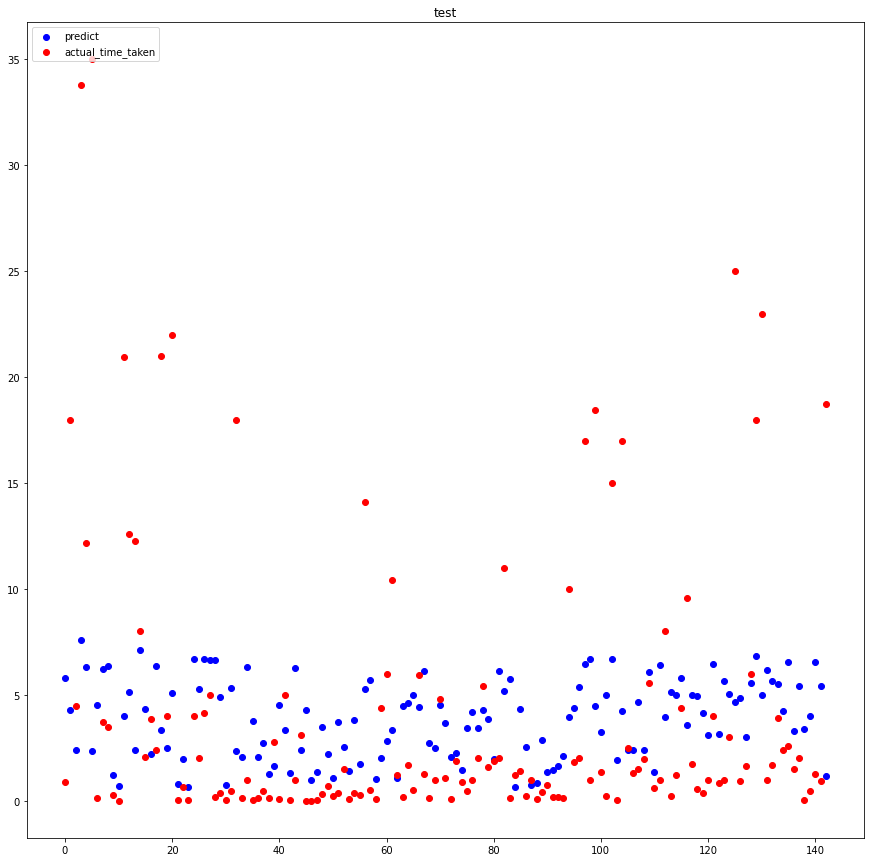

gbm prediction progress: |████████████████████████████████████████████████| 100%


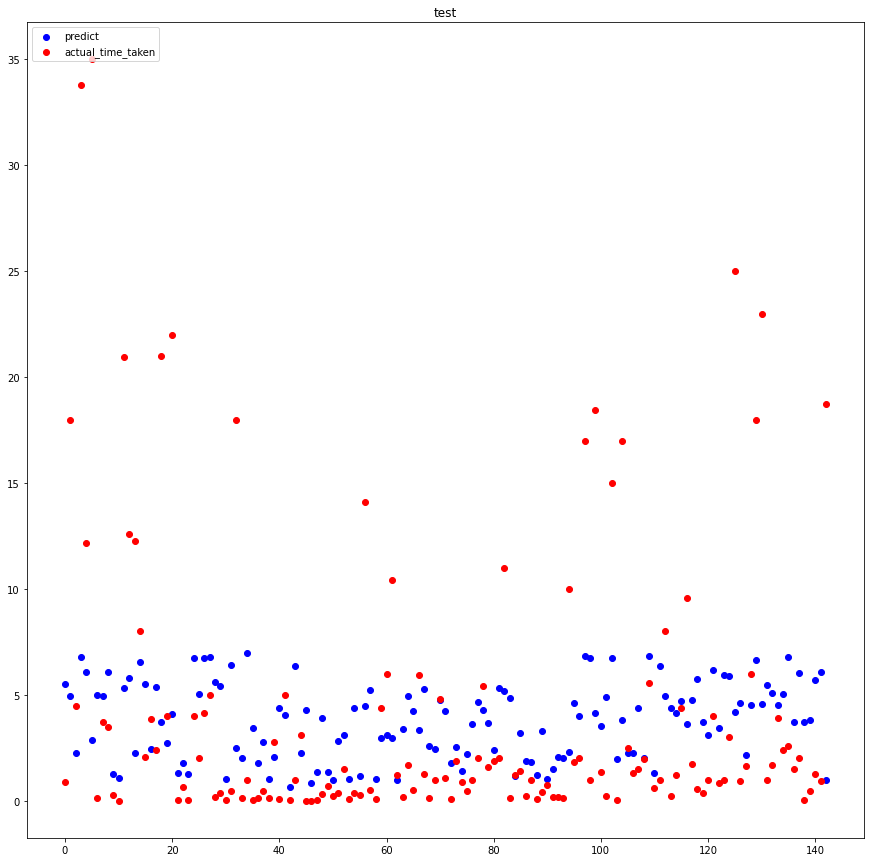

stackedensemble prediction progress: |████████████████████████████████████| 100%


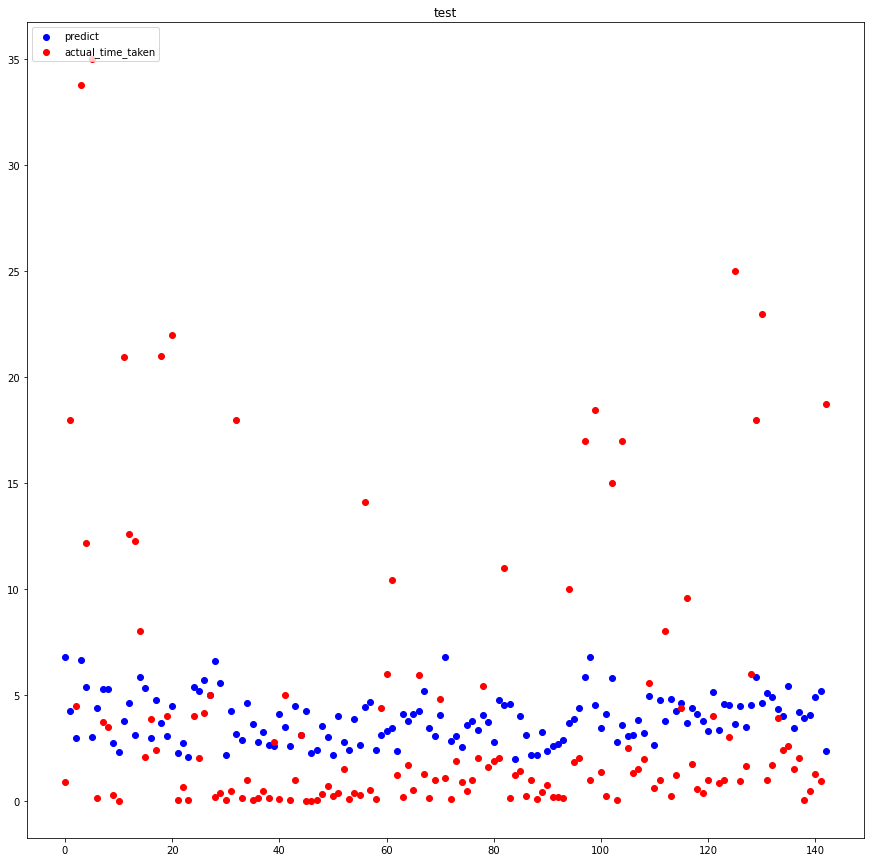

stackedensemble prediction progress: |████████████████████████████████████| 100%


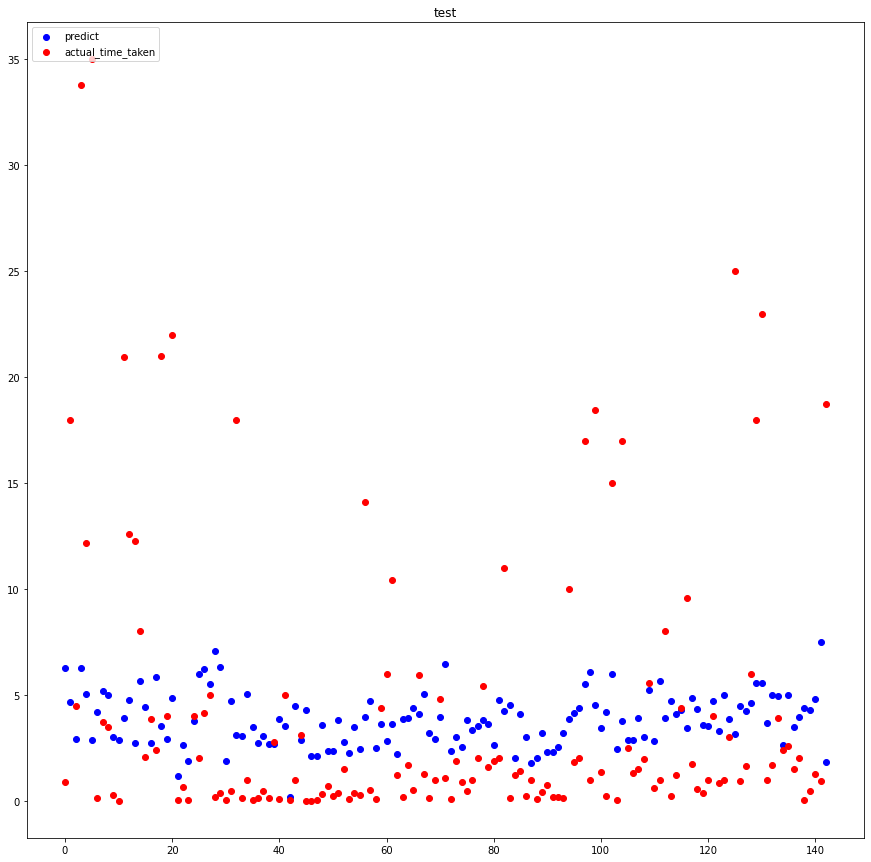

deeplearning prediction progress: |███████████████████████████████████████| 100%


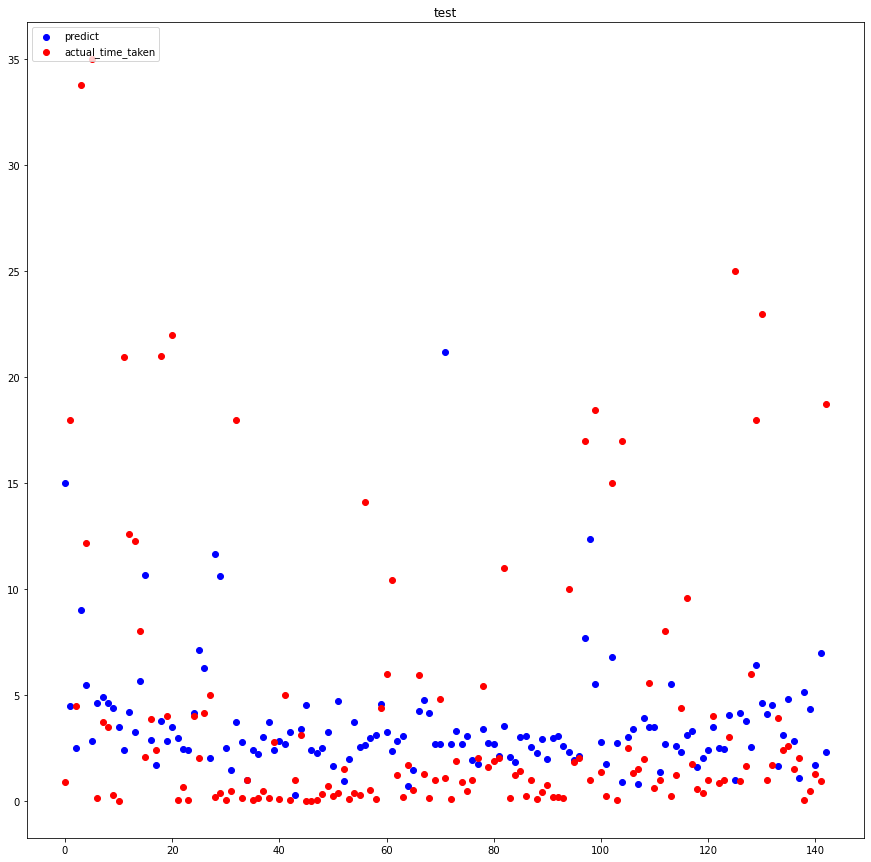

gbm prediction progress: |████████████████████████████████████████████████| 100%


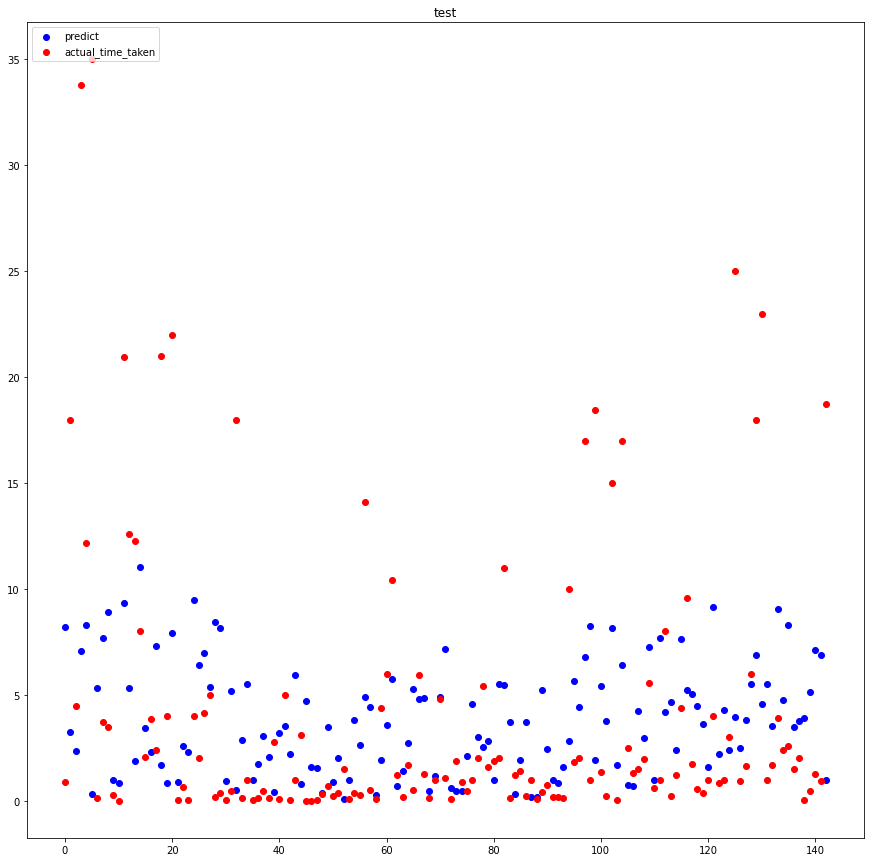

gbm prediction progress: |████████████████████████████████████████████████| 100%


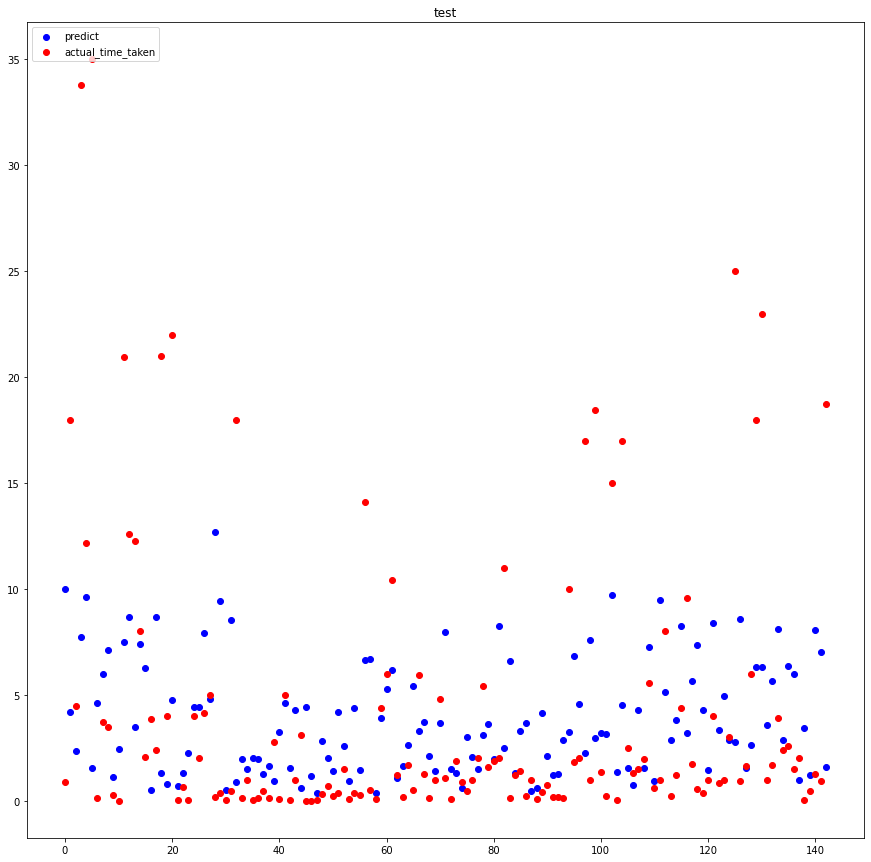

gbm prediction progress: |████████████████████████████████████████████████| 100%


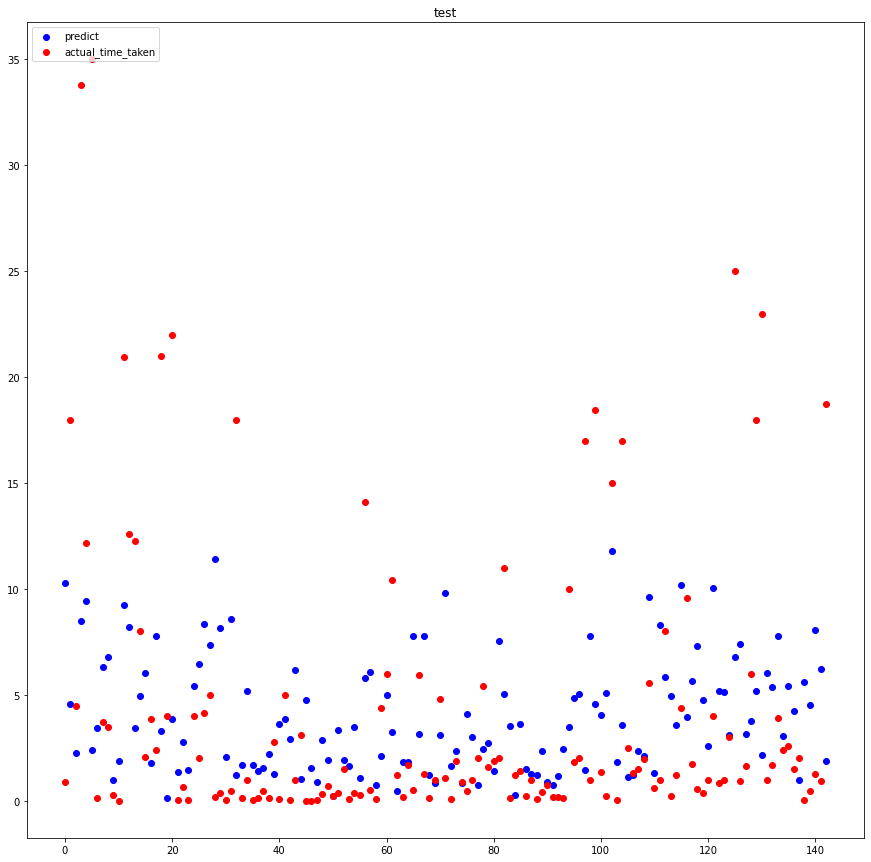

gbm prediction progress: |████████████████████████████████████████████████| 100%


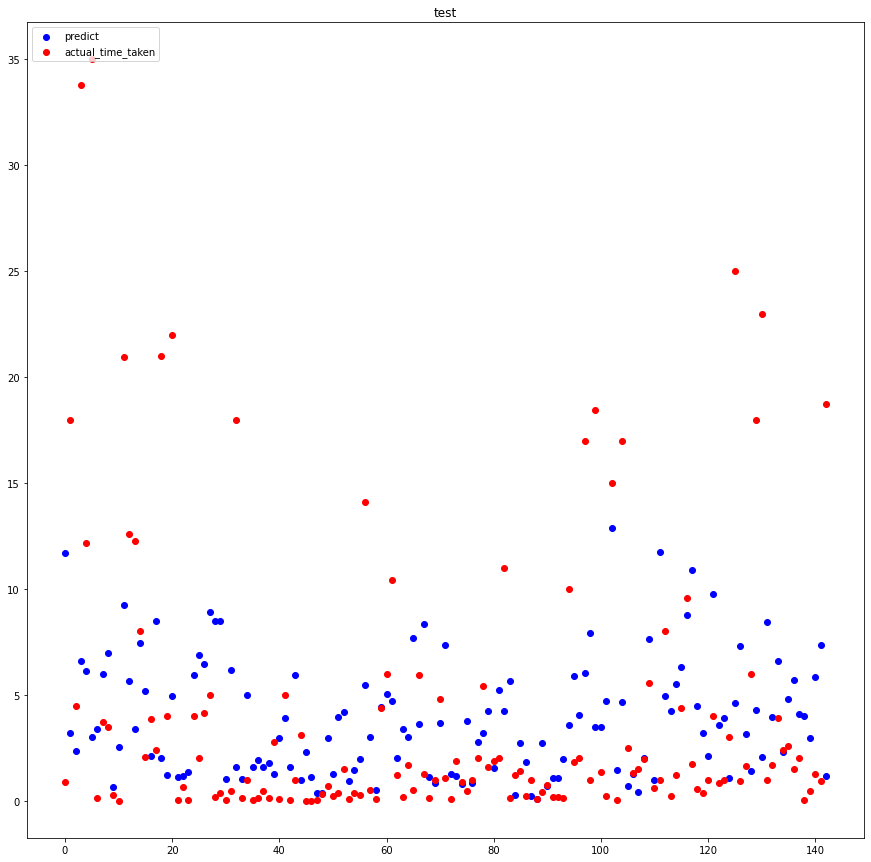

gbm prediction progress: |████████████████████████████████████████████████| 100%


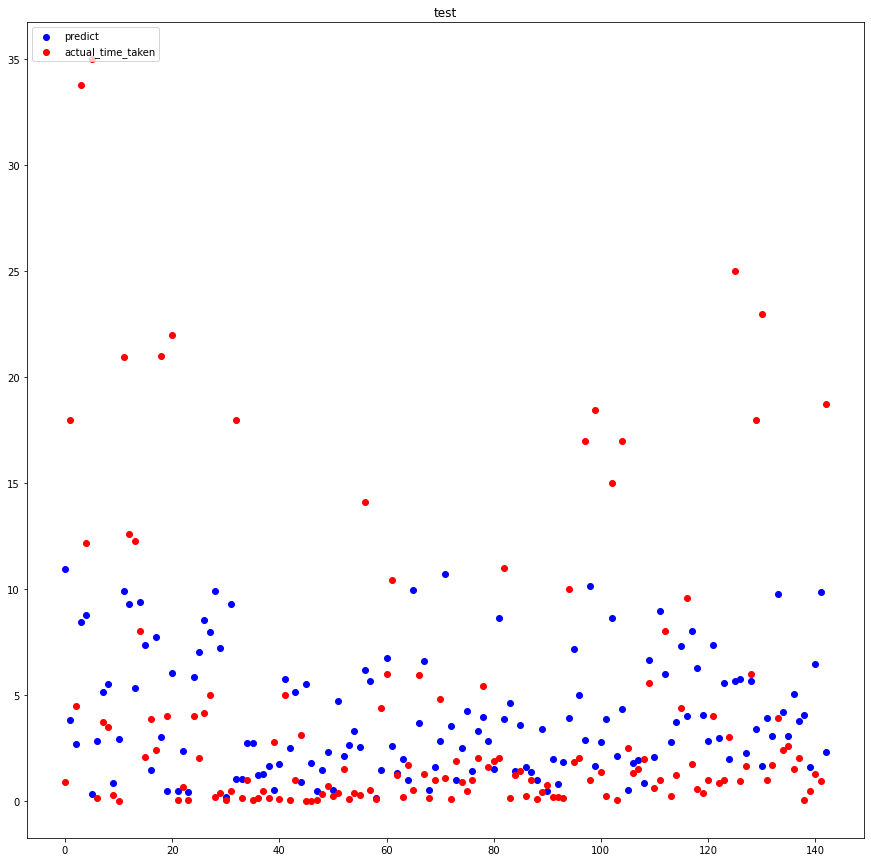

deeplearning prediction progress: |███████████████████████████████████████| 100%


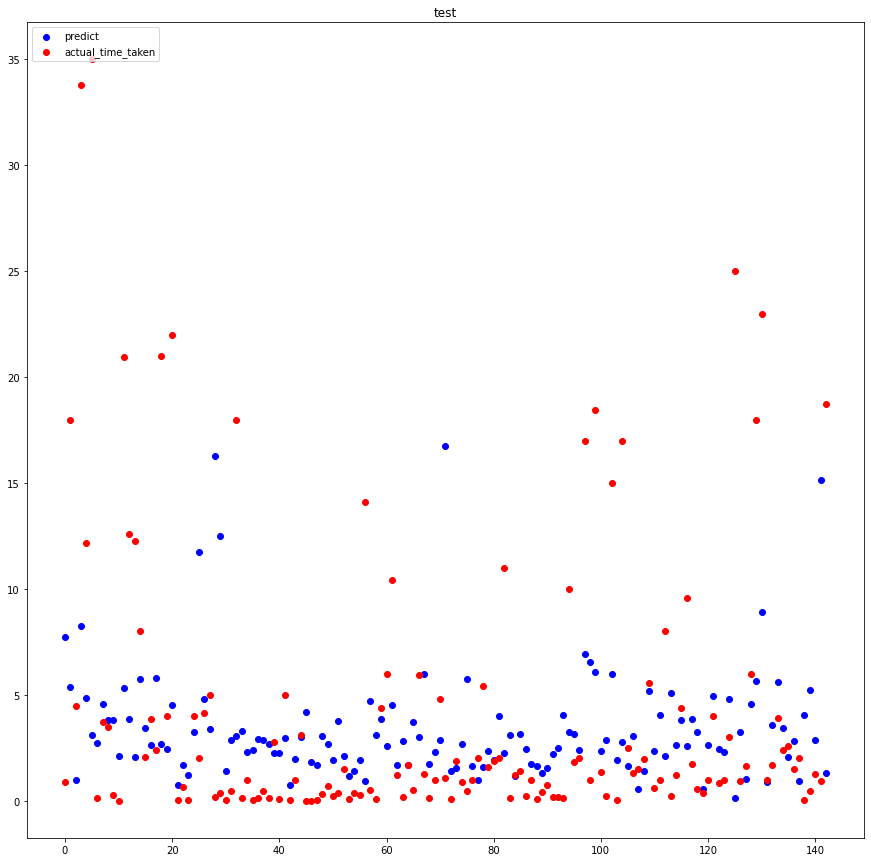

gbm prediction progress: |████████████████████████████████████████████████| 100%


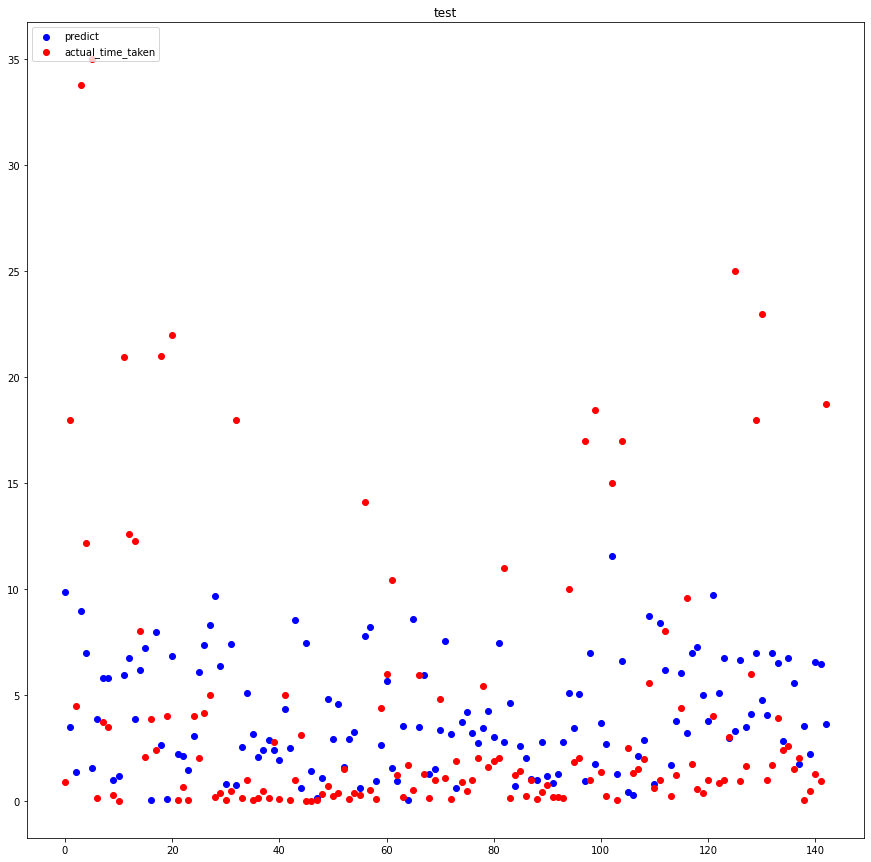

drf prediction progress: |████████████████████████████████████████████████| 100%


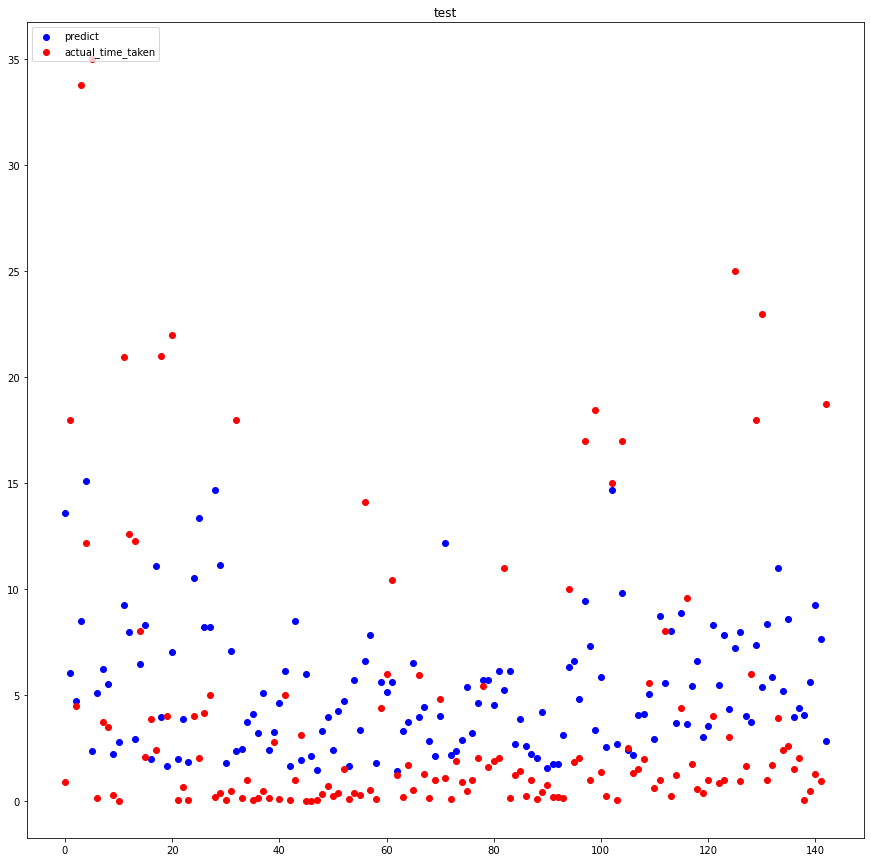

drf prediction progress: |████████████████████████████████████████████████| 100%


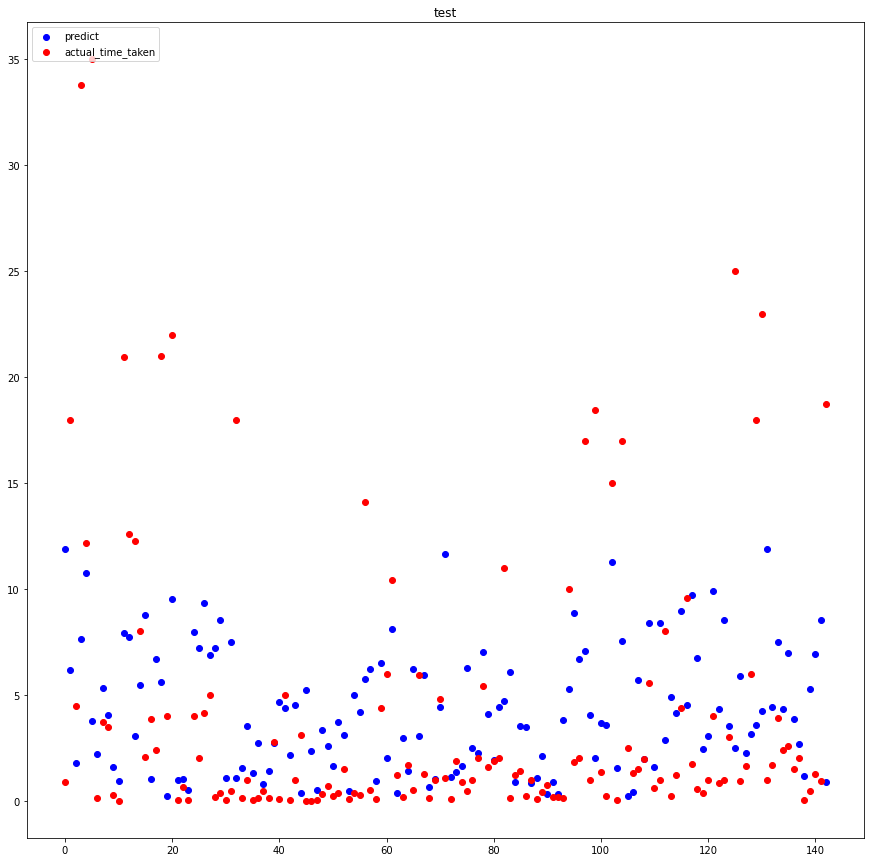

gbm prediction progress: |████████████████████████████████████████████████| 100%


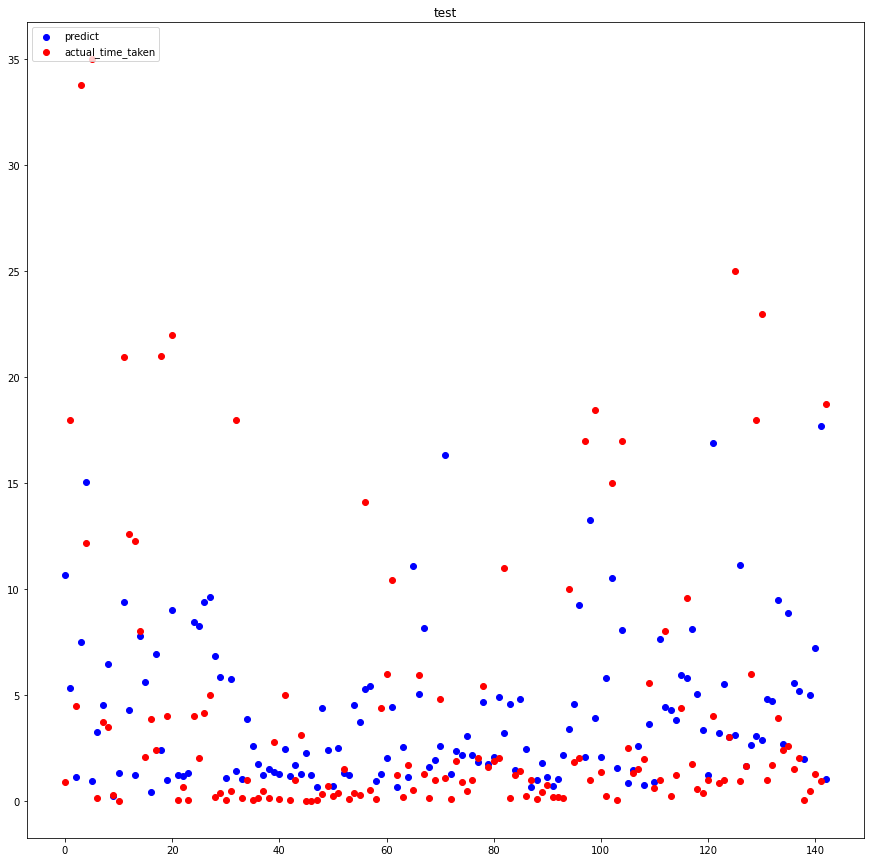

deeplearning prediction progress: |███████████████████████████████████████| 100%


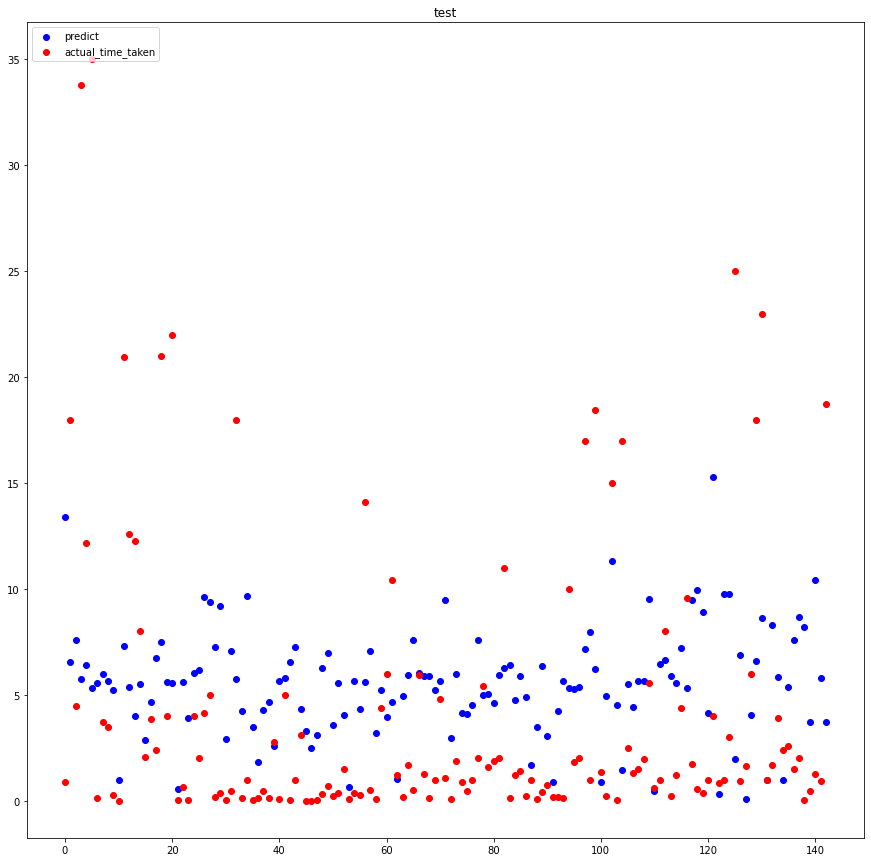

deeplearning prediction progress: |███████████████████████████████████████| 100%


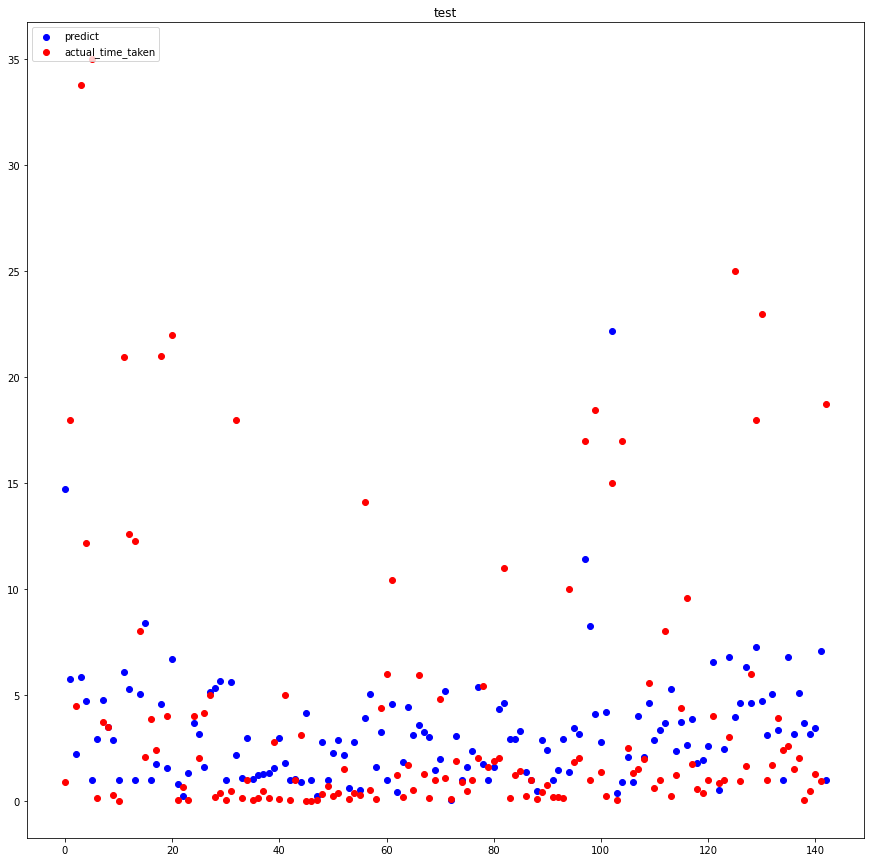

deeplearning prediction progress: |███████████████████████████████████████| 100%


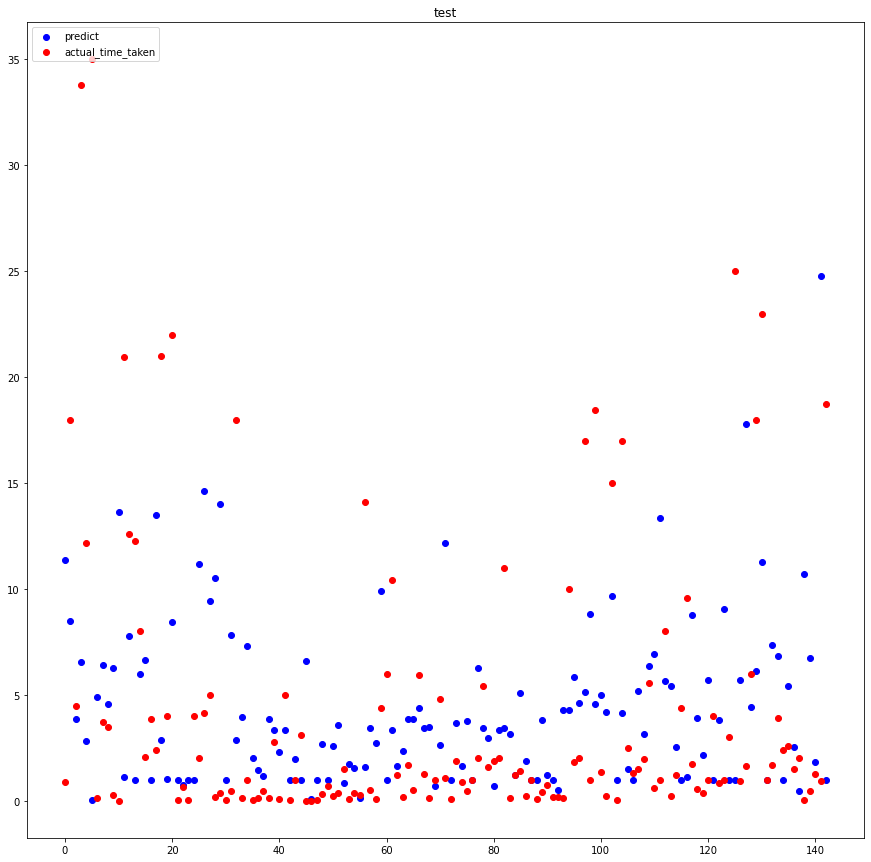

H2OResponseError: Server error water.exceptions.H2OKeyNotFoundArgumentException:
  Error: Object 'NA' not found for argument: key
  Request: GET /3/Models/NA


In [83]:
for i in range(25):
    model = h2o.get_model(lb[i,'model_id'])
    preds = model.predict(test)
    pd_preds = preds.as_data_frame()
    pd_test = test.as_data_frame()
    pd_preds['actual_time_taken'] = pd_test['refactoring_perc_time_taken']
    pd_preds.loc[(pd_preds.predict < 0),'predict']=1
    plotGraphandSave(pd_preds['predict'], pd_preds['actual_time_taken'],'predict','actual_time_taken','test', i)

In [84]:
model = h2o.get_model(lb[17,'model_id'])

In [85]:
model

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid__1_AutoML_20220213_044635_model_1


Status of Neuron Layers: predicting refactoring_perc_time_taken, regression, gaussian distribution, Quadratic loss, 15,601 weights/biases, 208.7 KB, 334,200 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,154,Input,0,,,,,,,,,
1,,2,100,RectifierDropout,20,0,0,0.0122673,0.0314427,0,0.00436155,0.204441,-0.155655,0.185228
2,,3,1,Linear,,0,0,0.00010759,4.35702e-05,0,-0.000609412,0.0654202,0.138488,1.09713e-154




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 16.274963712260394
RMSE: 4.0342240533044755
MAE: 2.2775325736051033
RMSLE: NaN
Mean Residual Deviance: 16.274963712260394

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 58.958983179995755
RMSE: 7.678475316102524
MAE: 5.3092277174697635
RMSLE: NaN
Mean Residual Deviance: 58.958983179995755

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,5.308101,1.1740476,6.9309483,4.3127327,4.0192456,5.70699,5.5705895
1,mean_residual_deviance,58.9229,25.923605,100.25825,37.684834,37.63337,53.415257,65.6228
2,mse,58.9229,25.923605,100.25825,37.684834,37.63337,53.415257,65.6228
3,r2,-0.44271544,0.44978866,-0.1266603,-0.2502309,-1.2321969,-0.37135664,-0.2331324
4,residual_deviance,58.9229,25.923605,100.25825,37.684834,37.63337,53.415257,65.6228
5,rmse,7.539134,1.6141406,10.012904,6.1387973,6.1346045,7.308574,8.10079
6,rmsle,NaN,0.0,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
0,,2022-02-13 04:47:54,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN
1,,2022-02-13 04:47:55,1 min 1.521 sec,17085 obs/sec,10.0,1,5570.0,7.058408,49.821123,4.343617,-0.060926
2,,2022-02-13 04:48:00,1 min 6.773 sec,18993 obs/sec,190.0,19,105830.0,5.003455,25.034558,3.207308,0.466897
3,,2022-02-13 04:48:05,1 min 11.909 sec,20298 obs/sec,390.0,39,217230.0,4.434991,19.669143,2.615897,0.581152
4,,2022-02-13 04:48:10,1 min 17.024 sec,21137 obs/sec,600.0,60,334200.0,4.034224,16.274964,2.277533,0.653430



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,num_dependency_mean,1.000000,1.000000,0.011635
1,num_line_affected_mean,0.919838,0.919838,0.010702
2,tryCatchQty_std,0.872682,0.872682,0.010153
3,finalMethods_std,0.862633,0.862633,0.010036
4,finalMethods_min,0.853752,0.853752,0.009933
5,dit_min,0.821548,0.821548,0.009558
6,staticFields_min,0.801407,0.801407,0.009324
7,anonymousClassesQty_min,0.790653,0.790653,0.009199
8,subClassesQty_min,0.785061,0.785061,0.009134
9,synchronizedMethods_min,0.783046,0.783046,0.009110



See the whole table with table.as_data_frame()


In [86]:
preds = model.predict(test)

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [87]:
preds

predict
11.3882
8.47593
3.85103
6.56164
2.82293
0.0323057
4.88823
6.43043
4.55379
6.27065


In [88]:
pd_preds = preds.as_data_frame()
pd_preds['predict'].value_counts()

 24.799581    1
 2.726665     1
-2.208244     1
 1.592351     1
 1.497981     1
             ..
 3.171782     1
 3.964572     1
-11.543163    1
 2.655257     1
 13.357245    1
Name: predict, Length: 143, dtype: int64

In [89]:
train

cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactoring_perc_time_taken
11,11,11,0,8,8,8,0,2,2,2,0,9,9,9,0,15,15,15,0,6,6,6,0,0,0,0,0,6,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,0,63,63,63,0,4,4,4,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,6,6,6,0,2,2,2,0,4,4,4,0,0,0,0,0,4,4,4,0,3,3,3,0,0,0,0,0,0,0,0,0,1,1,1,0,58,58,58,0,17,17,17,0,85,61,15
12,12,12,0,8,8,8,0,1,1,1,0,16,16,16,0,0,0,0,0,2,2,2,0,0,0,0,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,10,10,0,5,5,5,0,2,2,2,0,8,8,8,0,0,0,0,0,0,0,0,0,10,10,10,0,0,0,0,0,4,4,4,0,80,80,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,2,2,2,0,16,16,16,0,0,0,0,0,16,16,16,0,1,1,1,0,2,2,2,0,0,0,0,0,0,0,0,0,68,68,68,0,17,17,17,0,3,78,0.225434
30,30,30,0,29,29,29,0,1,1,1,0,78,78,78,0,0,0,0,0,27,27,27,0,0,0,0,0,27,27,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,12,0,0,0,0,0,2,2,2,0,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,0,350,350,350,0,0,0,0,0,2,2,2,0,0,0,0,0,1,1,1,0,0,0,0,0,24,24,24,0,72,72,72,0,82,82,82,0,5,5,5,0,81,81,81,0,1,1,1,0,0,0,0,0,0,0,0,0,6,6,6,0,103,103,103,0,1,1,1,0,78,322,1
23.25,5,63,20.7808,20.6667,4,64,21.9931,2,1,3,0.852803,40.4167,3,111,41.3597,27.1667,0,106,39.3512,15,3,37,13.1978,0.166667,0,1,0.389249,13.16

{'whiskers': [<matplotlib.lines.Line2D at 0x20265a9ab00>,
 'caps': [<matplotlib.lines.Line2D at 0x20265aa7240>,
 'boxes': [<matplotlib.lines.Line2D at 0x20265a9a9b0>],
 'medians': [<matplotlib.lines.Line2D at 0x20265aa7940>],
 'fliers': [<matplotlib.lines.Line2D at 0x20265aa7cc0>],
 'means': []}

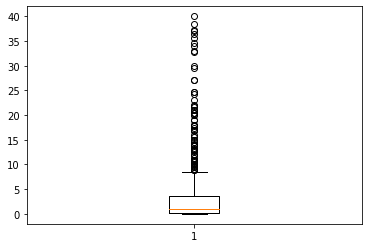

In [90]:
pd_train = train.as_data_frame()
plt.boxplot(pd_train['refactoring_perc_time_taken'])

In [91]:
main_df['actual_num_of_classes_touched_max'].mean()

49.925714285714285

In [92]:
len(main_df['actual_num_of_classes_touched_max'])

700

In [93]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 1000])

696

In [94]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 100])

656

In [95]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 50])

607

In [96]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 20])

515

In [97]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 10])

409

{'whiskers': [<matplotlib.lines.Line2D at 0x20265acbc18>,
 'caps': [<matplotlib.lines.Line2D at 0x20265ad1358>,
 'boxes': [<matplotlib.lines.Line2D at 0x20265acbac8>],
 'medians': [<matplotlib.lines.Line2D at 0x20265ad1a58>],
 'fliers': [<matplotlib.lines.Line2D at 0x20265ad1dd8>],
 'means': []}

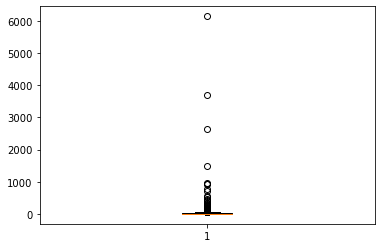

In [98]:
plt.boxplot(main_df['actual_num_of_classes_touched_max'])

In [99]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 1000]

{'whiskers': [<matplotlib.lines.Line2D at 0x20265c3c080>,
 'caps': [<matplotlib.lines.Line2D at 0x20265c3c748>,
 'boxes': [<matplotlib.lines.Line2D at 0x20265c30ef0>],
 'medians': [<matplotlib.lines.Line2D at 0x20265c3ce48>],
 'fliers': [<matplotlib.lines.Line2D at 0x20265c44208>],
 'means': []}

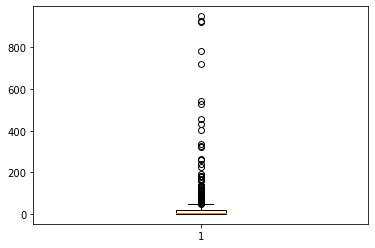

In [100]:
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

{'whiskers': [<matplotlib.lines.Line2D at 0x20265c8e8d0>,
 'caps': [<matplotlib.lines.Line2D at 0x20265c8efd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x20265c8e780>],
 'medians': [<matplotlib.lines.Line2D at 0x20265c98710>],
 'fliers': [<matplotlib.lines.Line2D at 0x20265c98a90>],
 'means': []}

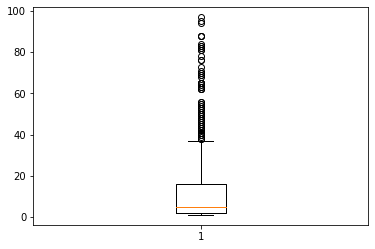

In [101]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 100]
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

In [102]:
pd_test = test.as_data_frame()
pd_preds['actual_time_taken'] = pd_test['refactoring_perc_time_taken']

In [107]:
pd_preds.loc[(pd_preds.predict < 0),'predict']=1

In [108]:
pd_preds

,predict,actual_time_taken
0,11.388162,0.865229
1,8.475932,18.000000
2,3.851028,4.462687
3,6.561644,33.817204
4,2.822935,12.173913
...,...,...
138,10.717765,0.056140
139,6.761162,0.467269
140,1.817358,1.263819
141,24.799581,0.944289


{'whiskers': [<matplotlib.lines.Line2D at 0x202673312b0>,
 'caps': [<matplotlib.lines.Line2D at 0x20267331978>,
 'boxes': [<matplotlib.lines.Line2D at 0x20267331160>],
 'medians': [<matplotlib.lines.Line2D at 0x2026733c0b8>],
 'fliers': [<matplotlib.lines.Line2D at 0x2026733c438>],
 'means': []}

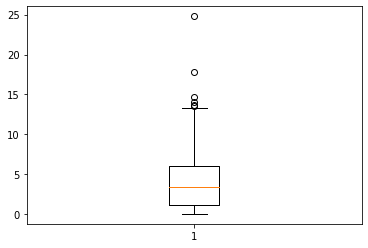

In [109]:
plt.boxplot(pd_preds['predict'])

{'whiskers': [<matplotlib.lines.Line2D at 0x2026738f908>,
 'caps': [<matplotlib.lines.Line2D at 0x2026738ffd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2026738f7b8>],
 'medians': [<matplotlib.lines.Line2D at 0x2026739b710>],
 'fliers': [<matplotlib.lines.Line2D at 0x2026739ba90>],
 'means': []}

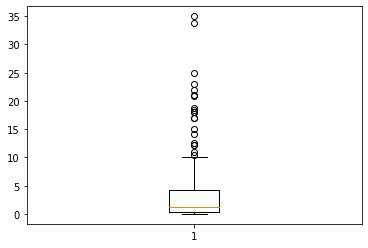

In [110]:
plt.boxplot(pd_preds['actual_time_taken'])

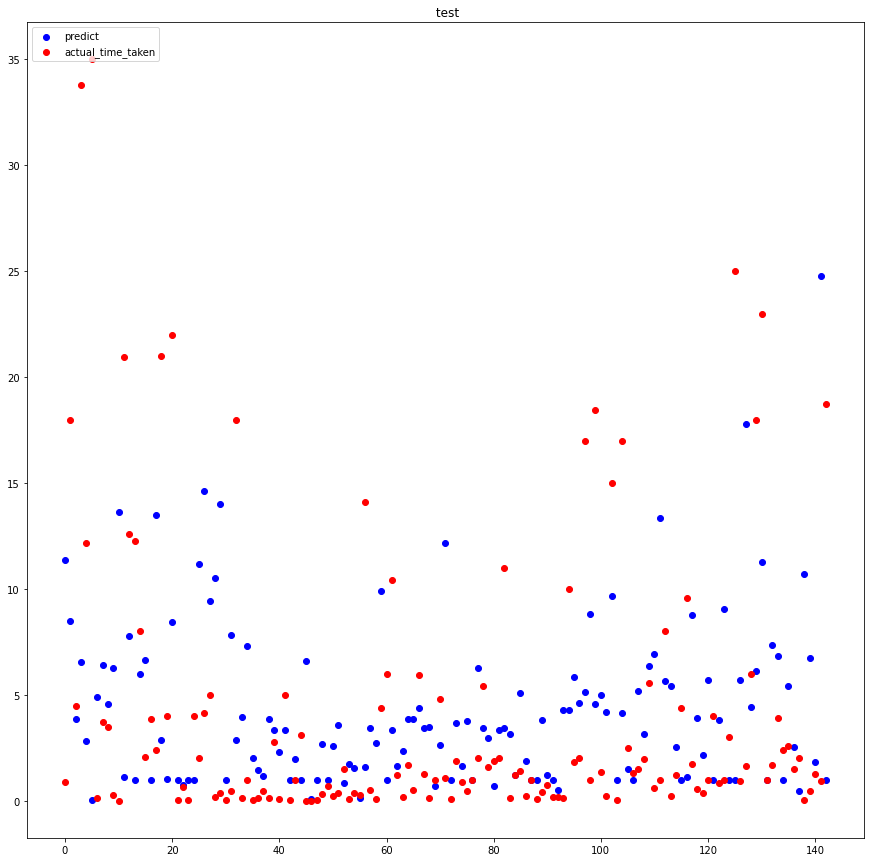

In [111]:
plotGraph(pd_preds['predict'], pd_preds['actual_time_taken'],'predict','actual_time_taken',' test')

In [112]:
visualization = pd_preds[pd_preds['predict'] <= 20]
visualization = pd_preds[pd_preds['actual_time_taken'] <= 20]


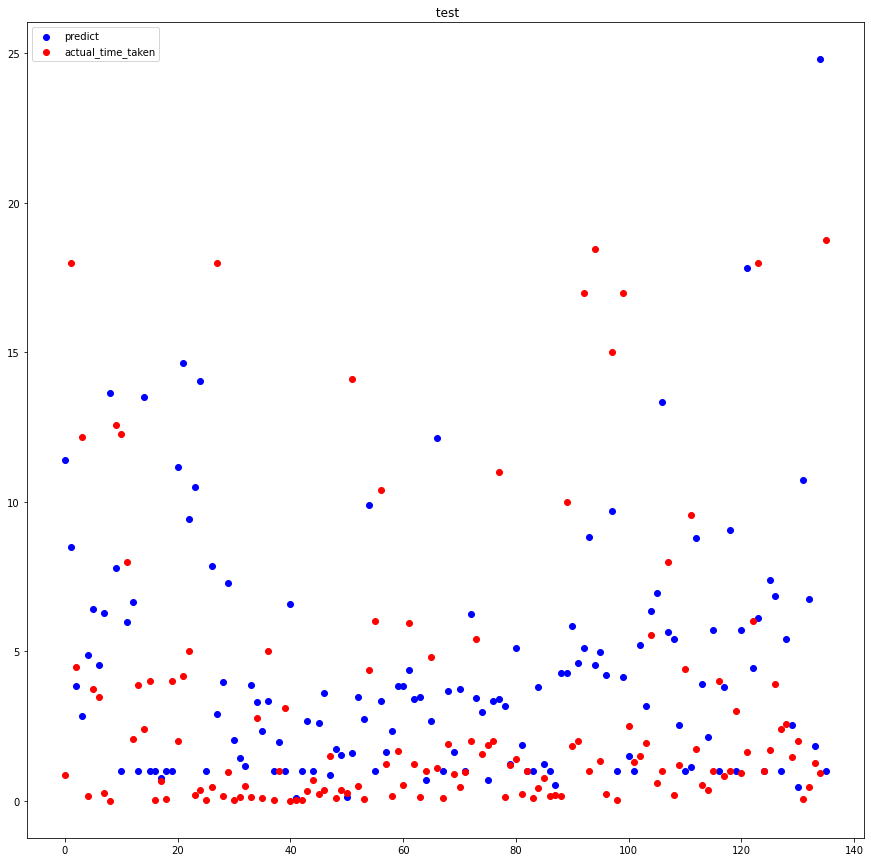

In [113]:
plotGraph(visualization['predict'], visualization['actual_time_taken'],'predict','actual_time_taken',' test')

In [114]:
# save the model
model_path = h2o.save_model(model=model, path="models/EffortEstimationModelv2", force=True)

Documentation at the following

https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/explanation/_explain.html

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

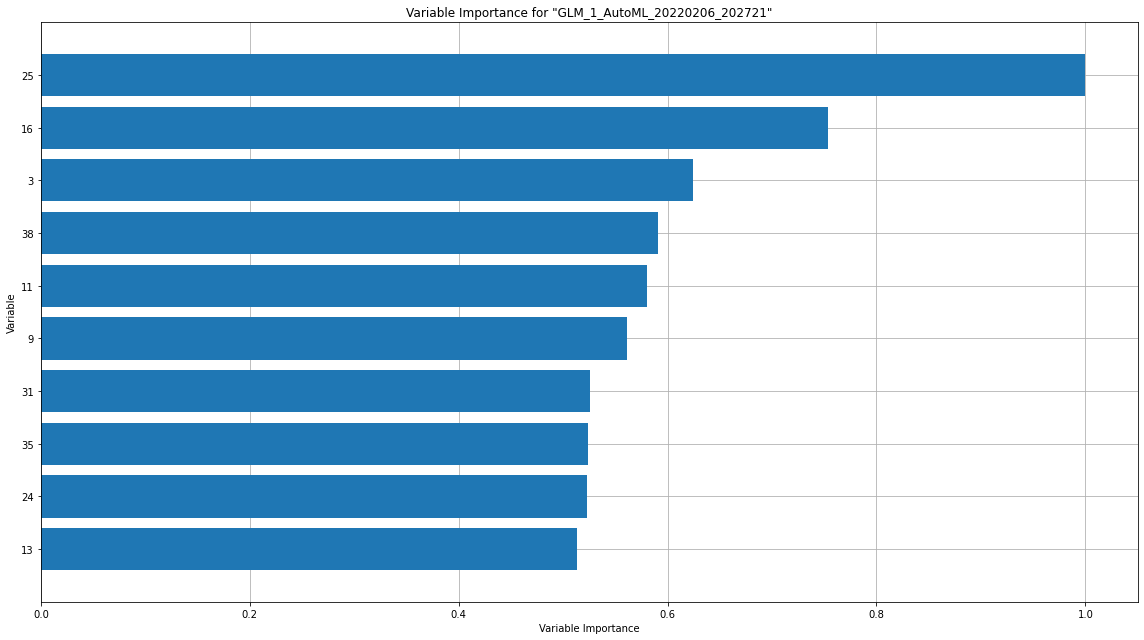

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

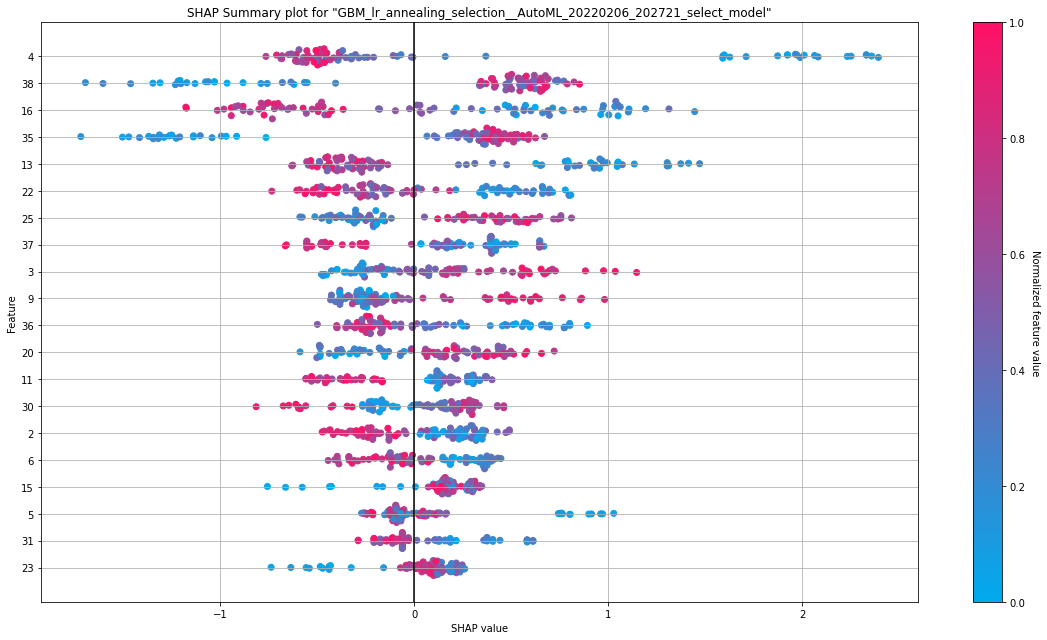

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

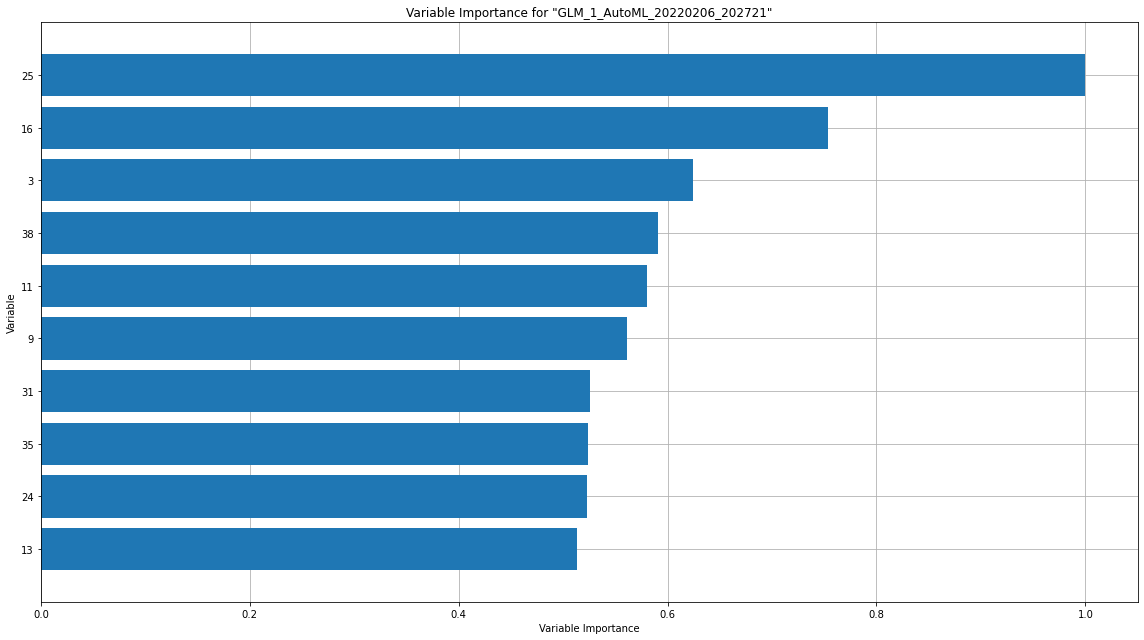

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

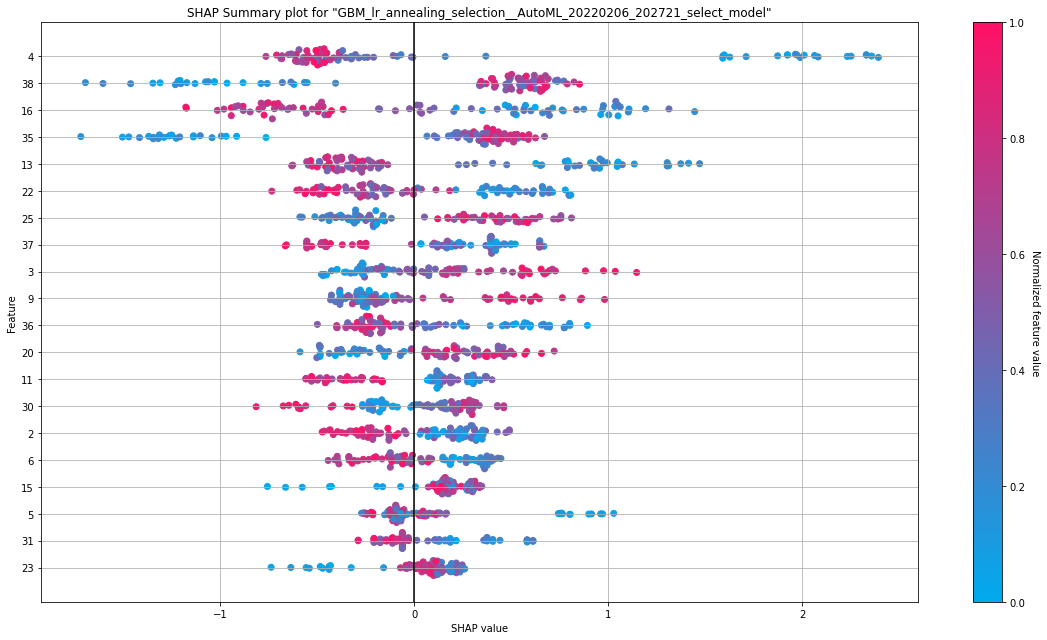

In [899]:
aml.explain(test, include_explanations=["varimp",'shap_summary'])

In [37]:
## Test calling of model

model_path = "models/EffortEstimationModelv2/Combined_Within3Days_21_DeepLearning_grid__3_AutoML_20220214_211909_model_1"
saved_model = h2o.load_model(model_path)

In [43]:
preds_read_model = saved_model.predict(test)
pd_preds_read_model = preds_read_model.as_data_frame()
pd_test = test.as_data_frame()
#pd_preds = preds.as_data_frame()
pd_preds_read_model['actual_time_taken'] = pd_test['refactoring_perc_time_taken']


deeplearning prediction progress: |███████████████████████████████████████| 100%


In [45]:
pd_preds_read_model.head()

,predict,actual_time_taken
0,12.792066,0.865229
1,17.331997,18.000000
2,3.822054,4.462687
3,12.218399,33.817204
4,11.140734,12.173913


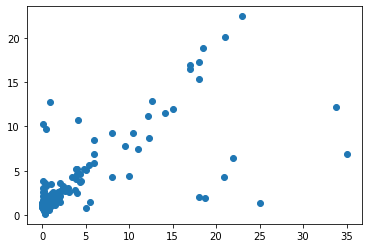

In [50]:
import matplotlib.pyplot as plt
plt.scatter(pd_preds_read_model['actual_time_taken'], pd_preds_read_model['predict'])

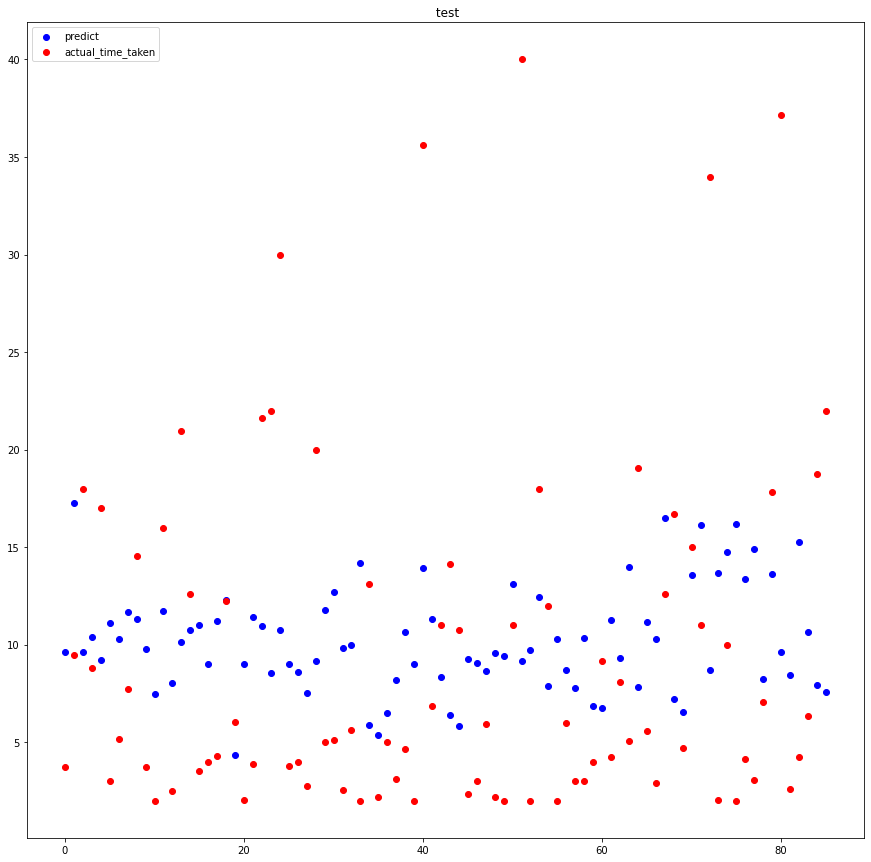

In [903]:
plotGraph(pd_preds_read_model['predict'], pd_preds_read_model['actual_time_taken'],'predict','actual_time_taken',' test')

In [ ]:
#aml.explain_row(test, row_index=0)

In [ ]:
#h2o.shutdown()